In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.metrics import f1_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.covariance import EmpiricalCovariance
from cuml import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import time
import tracemalloc

In [2]:
# 参数字典
default_params = {
    'pca_n_components': {
        'wine': [3, 0.95],
        'mnist': [50, 0.95],
        'cifar100': [100, 0.95]
    },
    'lda_n_components': None,
    'oversample': True
}

In [3]:
# 数据加载模块
def load_data(params):
    # 加载wine数据集
    wine = load_wine()
    X_wine = wine.data
    y_wine = wine.target

    # 加载mnist数据集
    mnist = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
    mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())

    # 加载cifar-100数据集
    transform = transforms.Compose([transforms.ToTensor()])
    cifar100_train = torchvision.datasets.CIFAR100(root='../data', train=True, download=True, transform=transform)
    cifar100_test = torchvision.datasets.CIFAR100(root='../data', train=False, download=True, transform=transform)
    return (X_wine, y_wine), (mnist, mnist_test), (cifar100_train, cifar100_test)

# 可视化CIFAR-100类以供选择
def visualize_cifar100_classes(cifar100_train):
    class_names = cifar100_train.classes
    fig, axs = plt.subplots(10, 10, figsize=(15, 15))
    fig.suptitle('CIFAR-100 Classes', fontsize=16)
    for i in range(100):
        class_idx = i
        class_name = class_names[class_idx]
        images = [img for img, label in cifar100_train if label == class_idx]
        axs[i // 10, i % 10].imshow(images[0].permute(1, 2, 0))
        axs[i // 10, i % 10].set_title(class_name, fontsize=8)
        axs[i // 10, i % 10].axis('off')
    plt.show()
    selected_classes = input("请输入您选择的类的索引（用逗号分隔）: ")
    selected_classes = [int(idx.strip()) for idx in selected_classes.split(',')]
    return selected_classes

# 数据描述模块
def describe_data(X, y, params):
    num_features = X.shape[1]
    unique_classes = np.unique(y)
    num_classes = len(unique_classes)
    fig, axs = plt.subplots(num_classes, num_features, figsize=(num_features * 3, num_classes * 3), squeeze=False)
    fig.suptitle('Feature Distributions per Class', fontsize=16)
    
    for class_idx, cls in enumerate(unique_classes):
        class_data = X[y == cls]
        for feature_idx in range(num_features):
            axs[class_idx, feature_idx].hist(class_data[:, feature_idx], bins=20, color='skyblue', alpha=0.7)
            axs[class_idx, feature_idx].set_title(f'Class {cls}, Feature {feature_idx}', fontsize=10)
            axs[class_idx, feature_idx].set_xlabel('Value')
            axs[class_idx, feature_idx].set_ylabel('Frequency')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    correlation_matrix = pd.DataFrame(X).corr()
    plt.figure(figsize=(12, 10))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.title('Feature Correlation Matrix')
    plt.show()

    if params['oversample'] and len(np.bincount(y)) > 1 and min(np.bincount(y)) / max(np.bincount(y)) < 0.5:
        print("数据不均衡，执行oversampling...")
        smote = SMOTE()
        X, y = smote.fit_resample(X, y)
    return X, y

# 数据处理模块
def normalize_data(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# PCA模块（使用scikit-learn实现）
def apply_pca(X, params, dataset_name):
    results = []
    X = X.astype('float32')
    for n_components in params['pca_n_components'][dataset_name]:
        pca = PCA(n_components=n_components, output_type='numpy')
        X_pca = pca.fit_transform(X)
        explained_variance = np.sum(pca.explained_variance_ratio_)
        print(f"PCA with n_components={n_components} for {dataset_name} dataset: Explained Variance = {explained_variance:.2f}")
        results.append((X_pca, explained_variance))
    return results

# LDA模块（使用scikit-learn实现）
def apply_lda(X_train, y_train, X_test, params):
    n_components = params['lda_n_components'] if params['lda_n_components'] else len(np.unique(y_train)) - 1
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    lda = LDA(n_components=n_components, output_type='numpy')
    X_lda_train = lda.fit_transform(X_train, y_train)
    X_lda_test = lda.transform(X_test)
    explained_variance = np.sum(lda.explained_variance_ratio_) if hasattr(lda, 'explained_variance_ratio_') else None
    return X_lda_train, X_lda_test, explained_variance

# 分类模块
def classify_data(X_train, y_train, X_test, y_test, classifier_name):
    classifiers = {
        'KNN': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression(),
        'Mahalanobis': EmpiricalCovariance()
    }
    clf = classifiers[classifier_name]
    print(f"\nRunning classifier: {classifier_name}")
    start_time = time.time()
    tracemalloc.start()

    if classifier_name == 'Mahalanobis':
        clf.fit(X_train)
        y_pred = [np.argmin([clf.mahalanobis(x.reshape(1, -1)) for x in X_test])]
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    current, peak = tracemalloc.get_traced_memory()
    end_time = time.time()
    tracemalloc.stop()

    result = {
        'f1_score': f1,
        'time_taken': end_time - start_time,
        'memory_usage': peak / 10**6  # 转换为MB
    }
    print(f"{classifier_name} 分类报告:\n", classification_report(y_test, y_pred))
    print(f"Time taken: {result['time_taken']:.2f} seconds, Peak memory usage: {result['memory_usage']:.2f} MB")
    return result

# 可视化比较降维后的分类结果
def visualize_comparison(results, dataset_name, classifier_name):
    methods = ['PCA', 'LDA', 'PCA + LDA', 'No Dimensionality Reduction']
    metrics = ['f1_score', 'time_taken', 'memory_usage']
    
    for metric in metrics:
        values = [results[method][metric] for method in methods]
        plt.figure(figsize=(10, 5))
        plt.bar(methods, values, color='skyblue')
        plt.xlabel('Dimensionality Reduction Method')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.title(f'{metric.replace("_", " ").title()} Comparison for {classifier_name} on {dataset_name} Dataset')
        plt.show()

In [4]:
# 主流程
def main(params):
    # 加载数据
    (X_wine, y_wine), (mnist, mnist_test), (cifar100_train, cifar100_test) = load_data(params)

    # 可视化CIFAR-100类并选择
    selected_classes = visualize_cifar100_classes(cifar100_train)
    selected_indices = [i for i, label in enumerate(cifar100_train.targets) if label in selected_classes]
    X_cifar100_selected = cifar100_train.data[selected_indices].reshape(len(selected_indices), -1)
    y_cifar100_selected = np.array([cifar100_train.targets[i] for i in selected_indices])

    datasets = {
        'wine': (X_wine, y_wine),
        # MNIST和CIFAR-100在这里用flatten的方式来表示
        'mnist': (mnist.data.view(-1, 28*28).numpy(), mnist.targets.numpy()),
        'cifar100': (X_cifar100_selected, y_cifar100_selected)
    }

    classifiers = ['KNN', 'Logistic Regression', 'Mahalanobis']  # 可以选择不同的分类器

    for classifier_name in classifiers:
        for dataset_name, (X, y) in datasets.items():
            # 描述数据
            X, y = describe_data(X, y, params)
            X = normalize_data(X)
            
            # 保存每种降维方法后的分类结果
            results = {}

            # PCA降维（无监督，使用全部数据）
            pca_results = apply_pca(X, params, dataset_name)
            for X_pca, explained_variance in pca_results:
                X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
                results[f'PCA ({explained_variance:.2f} variance)'] = classify_data(X_train_pca, y_train, X_test_pca, y_test, classifier_name)

            # 划分数据集
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # LDA分类（有监督，使用训练集训练LDA）
            X_lda_train, X_lda_test, lda_explained_variance = apply_lda(X_train, y_train, X_test, params)
            results['LDA'] = classify_data(X_lda_train, y_train, X_lda_test, y_test, classifier_name)

            # PCA后再LDA分类
            X_pca_train, X_pca_test = pca_results[0][0][:len(X_train)], pca_results[0][0][len(X_train):]
            X_pca_lda_train, X_pca_lda_test, _ = apply_lda(X_pca_train, y_train, X_pca_test, params)
            results['PCA + LDA'] = classify_data(X_pca_lda_train, y_train, X_pca_lda_test, y_test, classifier_name)

            # 不进行降维，直接分类
            results['No Dimensionality Reduction'] = classify_data(X_train, y_train, X_test, y_test, classifier_name)

            # 可视化比较结果
            visualize_comparison(results, dataset_name, classifier_name)

Files already downloaded and verified
Files already downloaded and verified


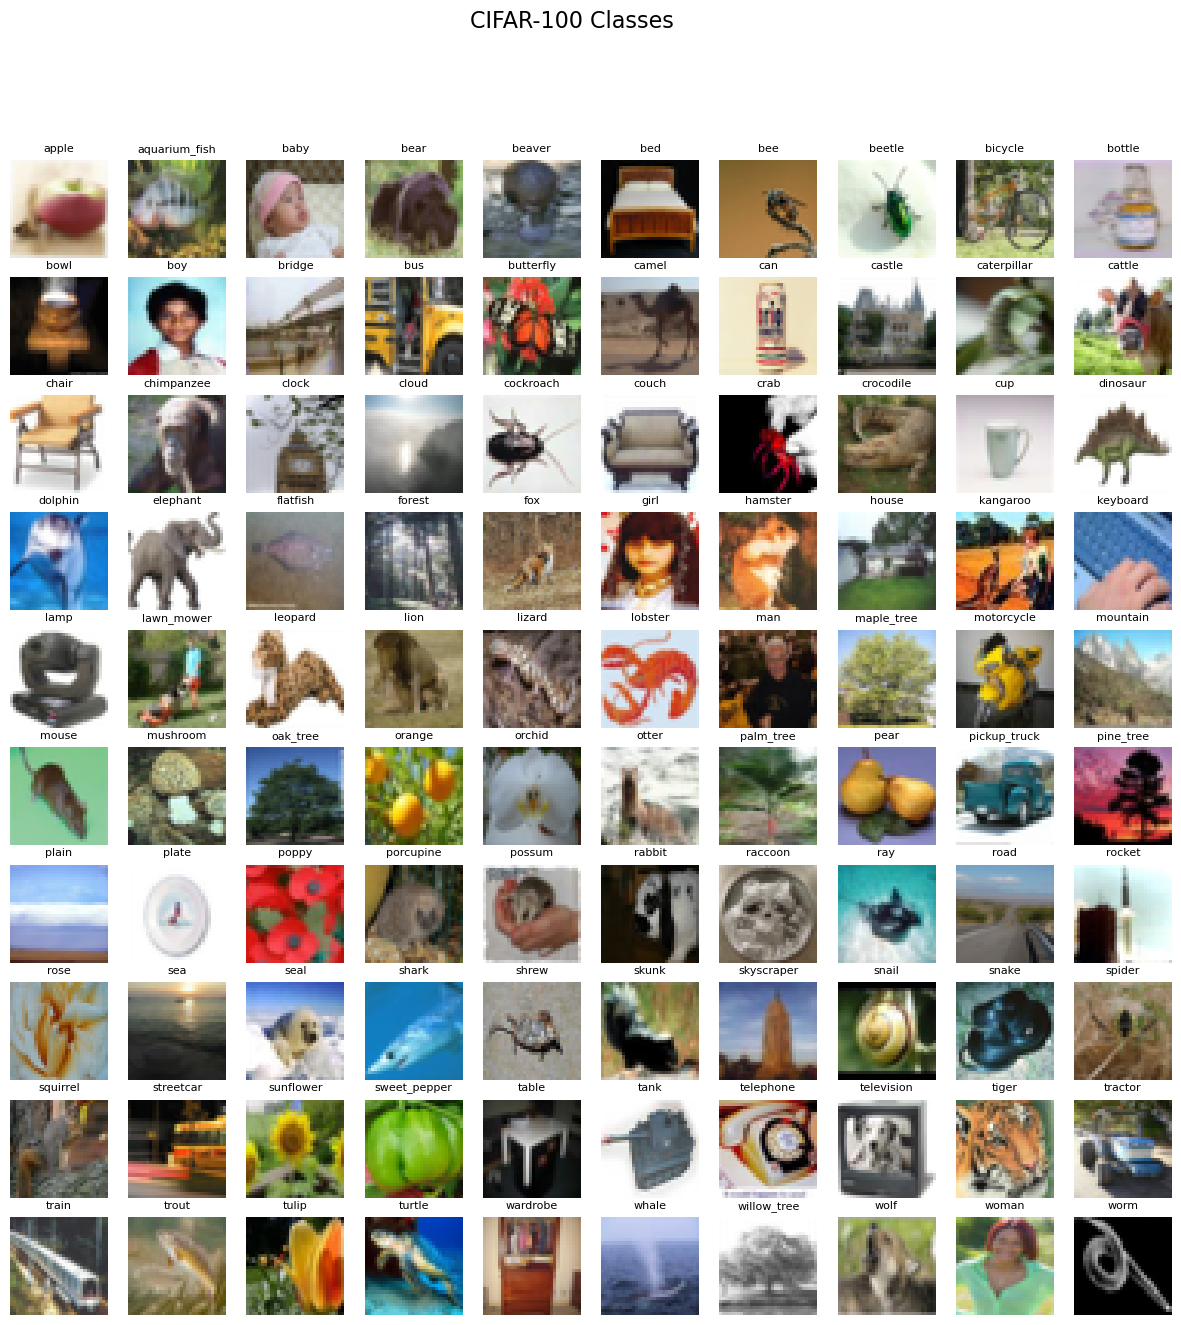

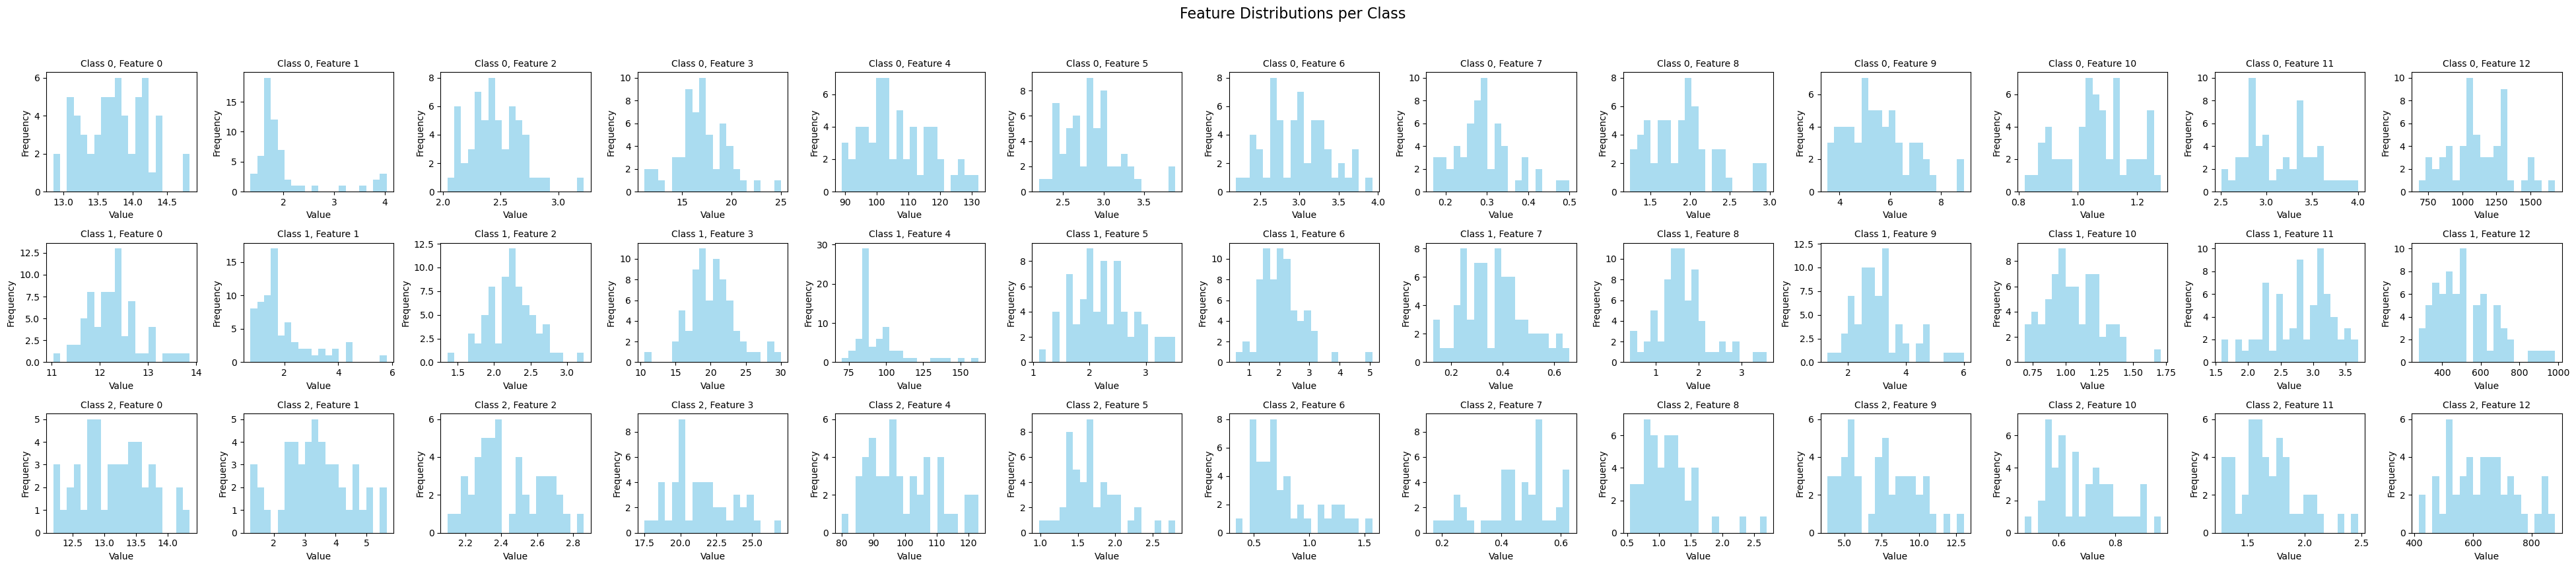

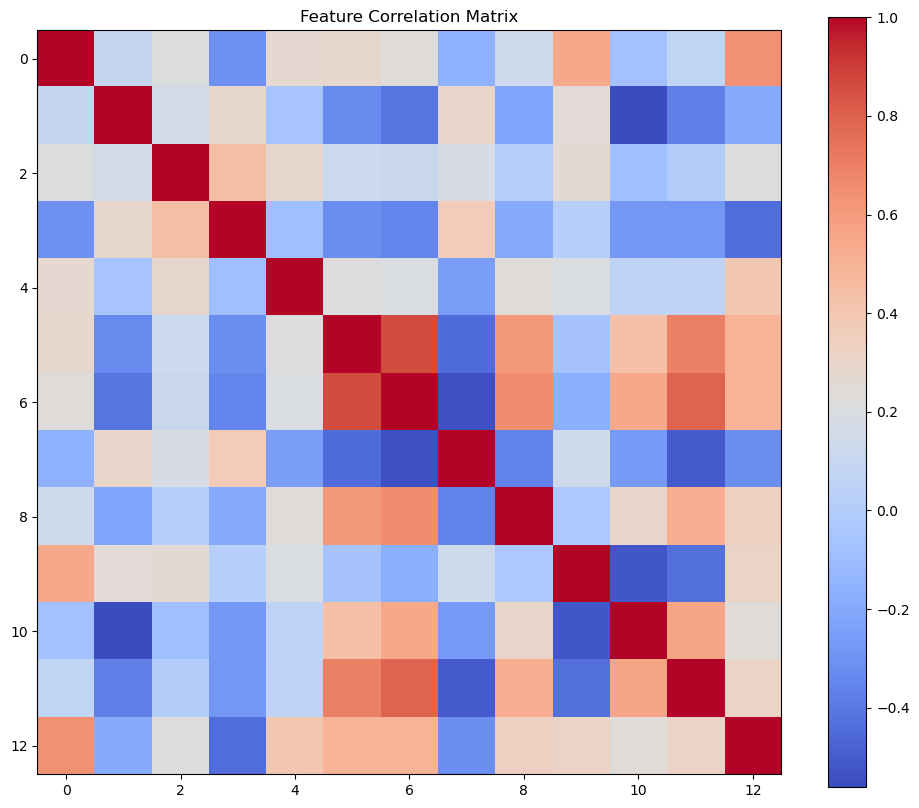

PCA with n_components=3 for wine dataset: Explained Variance = 0.67


RuntimeError: exception occurred! file=/opt/conda/conda-bld/work/cpp/src/pca/pca.cuh line=102: Parameter n_components: number of components cannot be less than one
Obtained 64 stack frames
#0 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/lib/python3.8/site-packages/cuml/internals/../../../../libcuml++.so(_ZN4raft9exception18collect_call_stackEv+0x84) [0x7f1c5723ffc4]
#1 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/lib/python3.8/site-packages/cuml/internals/../../../../libcuml++.so(+0x35aac4) [0x7f1c5711cac4]
#2 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/lib/python3.8/site-packages/cuml/decomposition/pca.cpython-38-x86_64-linux-gnu.so(+0x2d08e) [0x7f1dc29bf08e]
#3 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/lib/python3.8/site-packages/cuml/internals/base.cpython-38-x86_64-linux-gnu.so(+0x258fb) [0x7f1dc2e448fb]
#4 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(PyObject_Call+0x2af) [0x560508b5062f]
#5 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x1f72) [0x560508b34cd2]
#6 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalCodeWithName+0x2fd) [0x560508b31ddd]
#7 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyFunction_Vectorcall+0x18d) [0x560508b4285d]
#8 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x12b20e) [0x560508b4e20e]
#9 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(PyObject_Call+0x22a) [0x560508b505aa]
#10 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x1f72) [0x560508b34cd2]
#11 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalCodeWithName+0x2fd) [0x560508b31ddd]
#12 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyFunction_Vectorcall+0x18d) [0x560508b4285d]
#13 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(PyObject_Call+0x22a) [0x560508b505aa]
#14 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x1f72) [0x560508b34cd2]
#15 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalCodeWithName+0x2fd) [0x560508b31ddd]
#16 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(PyEval_EvalCodeEx+0x39) [0x560508bc7b99]
#17 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/lib/python3.8/site-packages/cuml/decomposition/pca.cpython-38-x86_64-linux-gnu.so(+0x22f0c) [0x7f1dc29b4f0c]
#18 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/lib/python3.8/site-packages/cuml/decomposition/pca.cpython-38-x86_64-linux-gnu.so(+0x27da1) [0x7f1dc29b9da1]
#19 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/lib/python3.8/site-packages/cuml/decomposition/pca.cpython-38-x86_64-linux-gnu.so(+0x27f29) [0x7f1dc29b9f29]
#20 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/lib/python3.8/site-packages/cuml/internals/base.cpython-38-x86_64-linux-gnu.so(+0x258fb) [0x7f1dc2e448fb]
#21 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(PyObject_Call+0x2af) [0x560508b5062f]
#22 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x1f72) [0x560508b34cd2]
#23 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalCodeWithName+0x2fd) [0x560508b31ddd]
#24 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyFunction_Vectorcall+0x18d) [0x560508b4285d]
#25 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x12b20e) [0x560508b4e20e]
#26 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(PyObject_Call+0x22a) [0x560508b505aa]
#27 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x1f72) [0x560508b34cd2]
#28 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalCodeWithName+0x2fd) [0x560508b31ddd]
#29 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyFunction_Vectorcall+0x18d) [0x560508b4285d]
#30 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(PyObject_Call+0x22a) [0x560508b505aa]
#31 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x1f72) [0x560508b34cd2]
#32 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalCodeWithName+0x2fd) [0x560508b31ddd]
#33 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x12b177) [0x560508b4e177]
#34 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x472e) [0x560508b3748e]
#35 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyFunction_Vectorcall+0xf6) [0x560508b427c6]
#36 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x3b3) [0x560508b33113]
#37 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalCodeWithName+0x2fd) [0x560508b31ddd]
#38 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyFunction_Vectorcall+0x18d) [0x560508b4285d]
#39 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x3b3) [0x560508b33113]
#40 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalCodeWithName+0x2fd) [0x560508b31ddd]
#41 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(PyEval_EvalCodeEx+0x39) [0x560508bc7b99]
#42 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(PyEval_EvalCode+0x1b) [0x560508bc7b5b]
#43 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x1a8b54) [0x560508bcbb54]
#44 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x120256) [0x560508b43256]
#45 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x3b3) [0x560508b33113]
#46 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x131fd5) [0x560508b54fd5]
#47 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x4a3f) [0x560508b3779f]
#48 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x131fd5) [0x560508b54fd5]
#49 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x4a3f) [0x560508b3779f]
#50 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x131fd5) [0x560508b54fd5]
#51 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x129c74) [0x560508b4cc74]
#52 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x6e6) [0x560508b33446]
#53 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyFunction_Vectorcall+0xf6) [0x560508b427c6]
#54 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x3b3) [0x560508b33113]
#55 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyFunction_Vectorcall+0xf6) [0x560508b427c6]
#56 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x6e6) [0x560508b33446]
#57 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalCodeWithName+0x2fd) [0x560508b31ddd]
#58 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyFunction_Vectorcall+0x18d) [0x560508b4285d]
#59 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x12b20e) [0x560508b4e20e]
#60 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(PyObject_Call+0x33a) [0x560508b506ba]
#61 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalFrameDefault+0x1f72) [0x560508b34cd2]
#62 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(_PyEval_EvalCodeWithName+0x2fd) [0x560508b31ddd]
#63 in /media/user/volume2/students/s124md209_01/anaconda3/envs/ml/bin/python(+0x12b177) [0x560508b4e177]


In [6]:
if __name__ == "__main__":
    main(default_params)